## Preliminary pop-gen of An hinesorum to support the MRC grant app

In [18]:
import allel
import seaborn as sns
import zarr
import xarray as xr
import plotly.express as px
import dask.array as da
import numpy as np
import json
import hashlib
import pandas as pd
import bokeh.plotting as bkplt
import bokeh.io as bkio
import bokeh.palettes as bokpalet
import bokeh.models as bkmod
import matplotlib.pyplot as plt
import cartopy
from Bio import SeqIO
from pathlib import Path
import sys

In [ ]:
# Define metadata and qc bool globally to start
#define useful variables
zarr_base_path = f"/scratch/user/uqtdenni/afar_production_bunya/curation/uq-beebe-001/combined_zarr/{{contig}}.zarr"

# Let's start by converting zarrs for the 5 largest contigs - we can do QC on them...
ref_path = '/scratch/user/uqtdenni/afar_production_bunya/reference/VectorBase-54_AfarautiFAR1_Genome.fasta'
# now let's get a list of the contigs that we are going to call over
contig_lengths = {}
for record in SeqIO.parse(ref_path, "fasta"):
    seq_id = record.id
    seq_length = len(record.seq)
    contig_lengths[seq_id] = seq_length
filtered_contigs = {k: v for k, v in sorted(contig_lengths.items(), key=lambda item: item[1], reverse=True) if v > 100000}

# Because these data are unstaged, we need to faff about a bit more and load the unstaged metadata to exclude extra dud samples
df_samples_dirty = pd.read_csv('/scratch/user/uqtdenni/far_hin_1.x/work/metadata_development_20250702/sample_metadata_interim_seq_qc_pass.txt', index_col = 'derived_sample_id')
# And load the final (cleaned) metadata
df_samples = pd.read_csv('/scratch/user/uqtdenni/far_hin_1.x/work/metadata_development_20250702/sample_metadata_pass_qc_fix.txt', index_col = 'derived_sample_id')

# Mask removing samples we removed before the staging step of QC (that I haven't done yet)
qc_bool = df_samples_dirty.index.isin(df_samples.index)

# Zarr location
zarr_base_path = f"/scratch/user/uqtdenni/afar_production_bunya/curation/uq-beebe-001/combined_zarr/{{contig}}.zarr"


In [21]:
# Define helper functions

def hash_params(*args, **kwargs):
    """Helper function to hash analysis parameters."""
    o = {
        'args': args,
        'kwargs': kwargs
    }
    s = json.dumps(o, sort_keys=True).encode()
    h = hashlib.md5(s).hexdigest()
    return h

# Define helper functions
def load_genotype_array(contig, qc_bool=qc_bool, df_samples=df_samples, sample_query = None, n_snps=None):
    # Load gts and remove failed qc samples
    z = zarr.open(zarr_base_path.format(contig=contig))
    
    # Variant-level mask: punctulatus_group_filter_pass
    filter_mask = z[f"{contig}/punctulatus_group_filter_pass"][:]

    gt = allel.GenotypeChunkedArray(z[f"{contig}/calldata/GT"])
    
    # Apply combined variant mask
    gt = allel.GenotypeChunkedArray(z[f"{contig}/calldata/GT"])
    gt = gt.compress(qc_bool, axis=1)          # Filter samples by QC
    gt = gt.compress(filter_mask, axis=0)    # Filter variants
    
    # If an additional mask is supplied to subset the data from the finished metadata, apply, else return all samples
    if sample_query is not None:
        bool_query = np.array(df_samples.eval(sample_query))
        gt = gt.compress(bool_query, axis=1)
    if n_snps is not None:
            gt = select_random_genotypes_sorted(gt, n_snps)

    return gt


def select_random_elements_sorted(g, x, replace=False, seed=None):
    """
    Select x random rows from a 2D array, returned in sorted order.

    Parameters:
    - array: array 2d, shape (n_genotypes, n_features)
    - x: int, number of rows to select
    - replace: bool, whether sampling is with replacement (default: False)
    - seed: int, random seed for reproducibility (default: None)

    Returns:
    - np.ndarray of shape (x, n_features)
    """

    # Select random sites from that set
    rng = np.random.default_rng(seed)
    n_rows = g.shape[0]
    if not replace and x > n_rows:
        raise ValueError(f"Cannot select {x} rows without replacement from {n_rows} total rows.")
    indices = rng.choice(n_rows, size=x, replace=replace)
    sorted_indices = np.sort(indices)

    return g[sorted_indices]

def compute_ac(contig, is_biallelic=True, is_segregating=True, min_minor_ac=1, n_snps=None, sample_query=None, to_alt = None):
    
    g = load_genotype_array(contig=contig, qc_bool = qc_bool, sample_query=sample_query)  
    
    ac = g.count_alleles()
    
    mask = None
    
    # Apply biallelic filter
    if is_biallelic:
        biallelic_mask = ac.is_biallelic()
        mask = biallelic_mask if mask is None else mask & biallelic_mask
    
    # Apply segregating filter
    if is_segregating:
        segregating_mask = ac.is_segregating()
        mask = segregating_mask if mask is None else mask & segregating_mask
    
    # Apply minor allele count filter
    if min_minor_ac is not None:
        an = ac.sum(axis=1)
    # Apply minor allele count condition.
        ac_minor = ac[:, 1:].sum(axis=1)
        if isinstance(min_minor_ac, float):
            ac_minor_frac = ac_minor / an
            loc_minor_mask = ac_minor_frac >= min_minor_ac
        else:
            loc_minor_mask = ac_minor >= min_minor_ac
        mask = loc_minor_mask if mask is None else mask & loc_minor_mask
    
    # Apply all filters at once
    if mask is not None:
        gt = g.compress(mask)
    
    # Random selection (if needed)
    if n_snps is not None:  # Fixed: 'if' instead of 'is'
        gt = select_random_elements_sorted(gt, n_snps)
    
    if to_alt is not None:
        return gt.to_n_alt()
    else:
        return gt.count_alleles()
    
def run_pca(contig, sample_df=df_samples, analysis_name='pca', n_snps=50_000, sample_query = None, results_dir='results_cache', min_minor_ac=1, n_components=10):

        # construct a key to save the results under
    results_key = hash_params(
        contig=contig,
        sample_query=sample_query,
        analysis_name=analysis_name,
        min_minor_ac=min_minor_ac,
        n_snps=n_snps,
        n_components=n_components,
    )

    # define paths for results files
    data_path = f'{results_dir}/{results_key}-data.csv'
    evr_path = f'{results_dir}/{results_key}-evr.npy'

    try:
        # try to load previously generated results
        data = pd.read_csv(data_path)
        evr = np.load(evr_path)
        return data, evr
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')
    
    print('setting up inputs')

    # Load data

    # Prepare input matrix
    g = load_genotype_array(contig=contig, qc_bool = qc_bool, sample_query=sample_query) # Load genotypes
    ac = g.count_alleles() #Count alleles
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) # Remove singletons and multiallelics
    gf = g.compress(flt, axis=0) #Apply filter
    gn = select_random_elements_sorted(gf, n_snps).to_n_alt() # Select random n snps

    # Subset sample df
    if sample_query is not None:
        df=sample_df.query(sample_query)
    else:
        df=sample_df

    # Run PCA
    coords, model = allel.pca(gn, n_components=10, scaler='patterson') # Run PCA
    df_coords = pd.DataFrame(
        {f"PC{i + 1}": coords[:, i] for i in range(coords.shape[1])}
    )    
    data = pd.concat([df.reset_index(), df_coords.reset_index(drop=True)], axis=1)

    #Save output
    evr = model.explained_variance_ratio_
    data.to_csv(data_path, index=False)
    np.save(evr_path, evr)
    print(f'saved results: {results_key}')

    return data, evr

def plot_pca(data, evr, i='PC1',j='PC2', colourfac='species_pca'):

        #xlab = f"PC{int(i)+1}, {evr[int(i)] * 100:.2f}%"
        #ylab = f"PC{int(j)+1}, {evr[int(j)] * 100:.2f}%"
        
        fig = px.scatter(data,
                    x=i,
                    y=j,
                    color=colourfac,
                    template='simple_white',
                    hover_data = ['derived_sample_id','species','country','admin1_iso','admin1_name','divergence','median_cov', 'latitude','longitude'],
                    width = 600, height=500,
        )
        # Add axis titles
        #fig.update_layout(
        #        xaxis_title=xlab,
        #        yaxis_title=ylab
        #)
    
        fig.show()



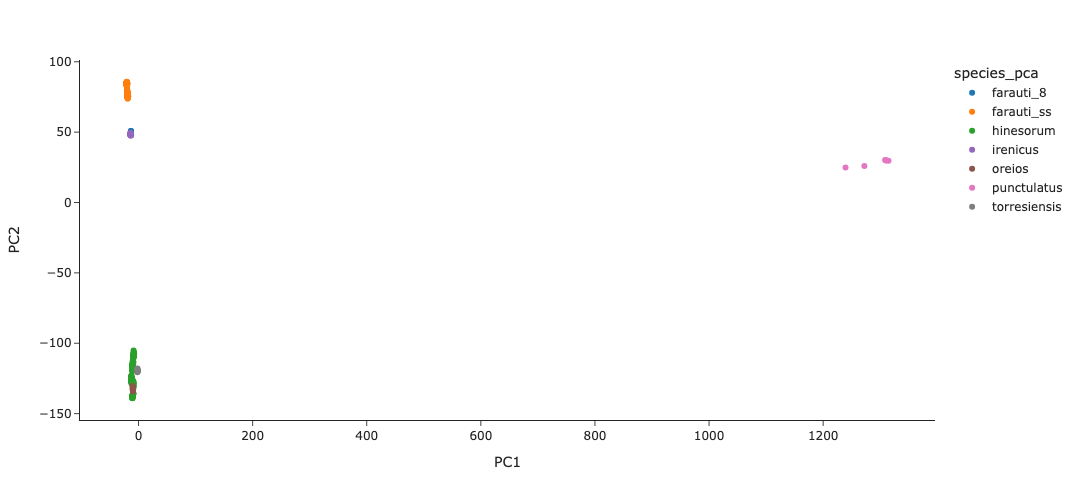

In [22]:
model_all, evr_all = run_pca(contig = "KI915040", n_snps=50_000)
plot_pca(model_all, evr_all)

In [ ]:
outputlist = {}
for c in filtered_contigs.keys():
    print(c)
    data, evr = run_pca(contig = c,sample_query = 'species_pca == "hinesorum" & partner_sample_id != "hin_WPSL_sol86"', n_snps=50_000)
    outputlist[f'{c}'] = (data, evr)
    

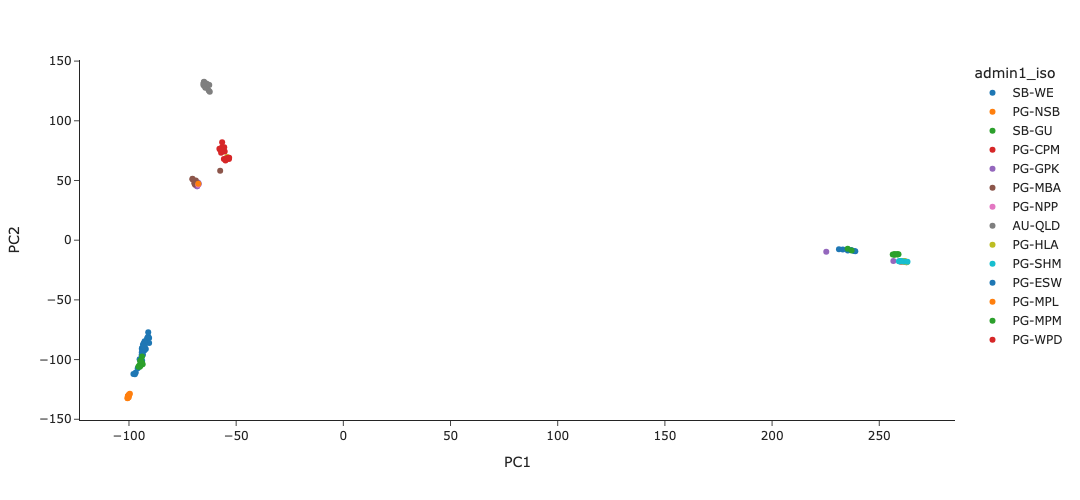

In [24]:
ct = list(filtered_contigs.keys())[0]
plot_pca(outputlist[ct][0], outputlist[ct][1], colourfac = 'admin1_iso')

In [ ]:
c = list(filtered_contigs.keys())[0]
si_pca_hin = run_pca(contig = c,sample_query = 'species == "hinesorum" & partner_sample_id != "hin_WPSL_sol86" & (admin1_iso == "PG-NSB" | country_iso == "SB")', n_snps=50_000)


In [ ]:
plot_pca(si_pca_hin[0], si_pca_hin[1], colourfac = 'admin1_iso')

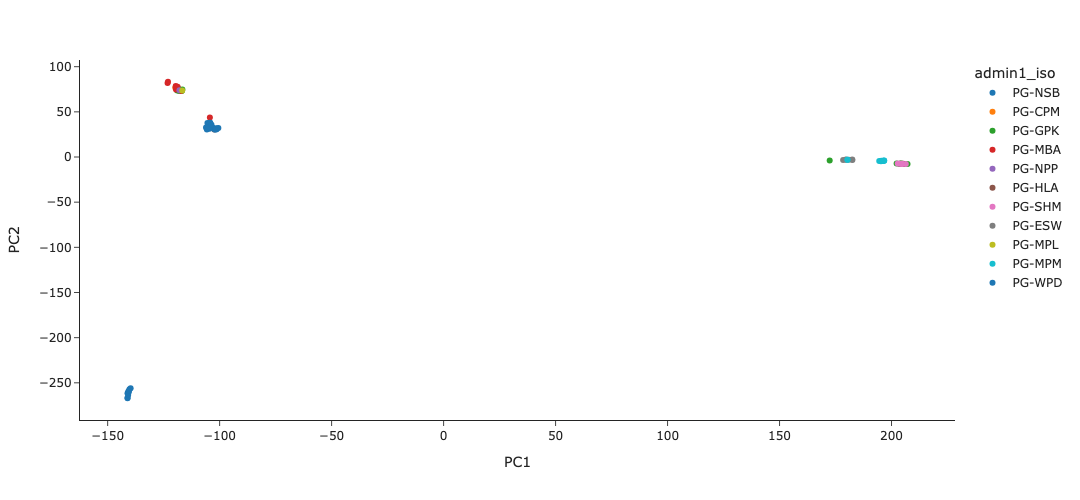

In [27]:
model_all, evr_all = run_pca(contig = "KI915040", n_snps=50_000, sample_query = 'species_pca == "hinesorum" & country_iso == "PG"')
plot_pca(model_all, evr_all, colourfac = 'admin1_iso')